# Trappist1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fnames = glob('/Volumes/Nibelheim/hst/data/TRAPPIST/*.fits')

In [4]:
obs = om.Observation.from_files(fnames)

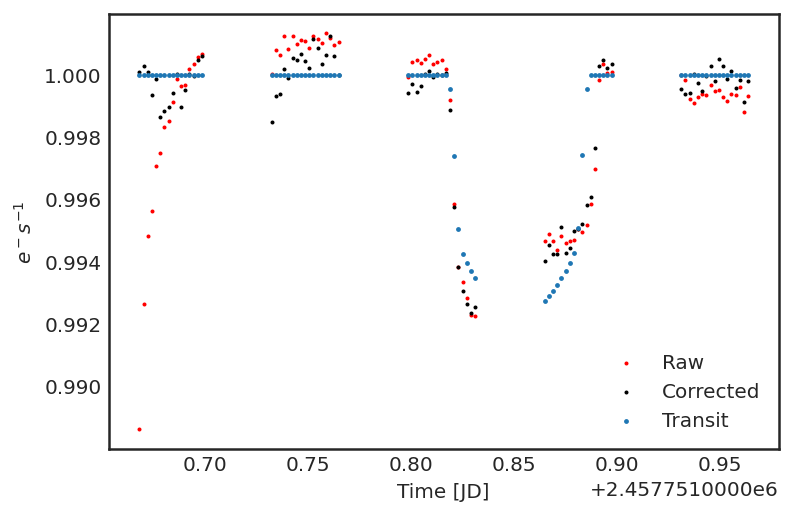

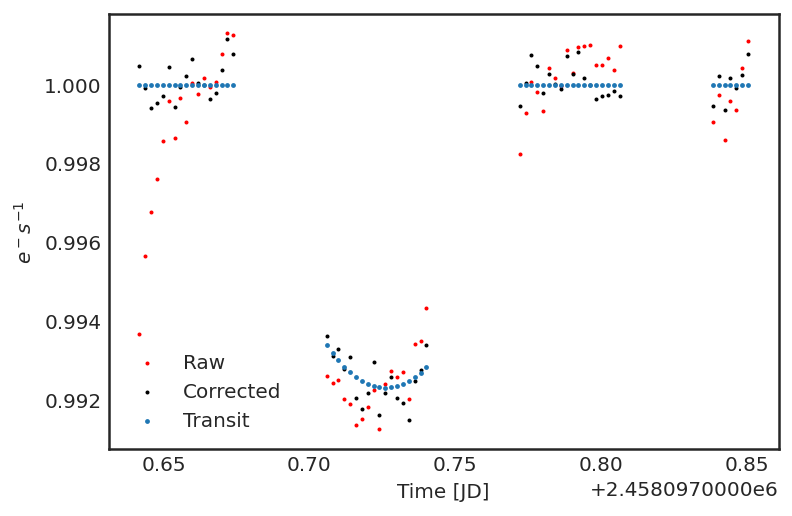

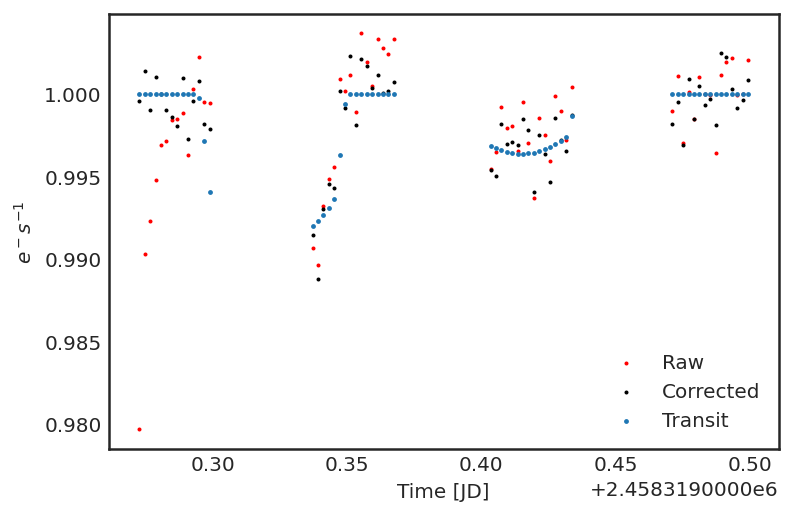

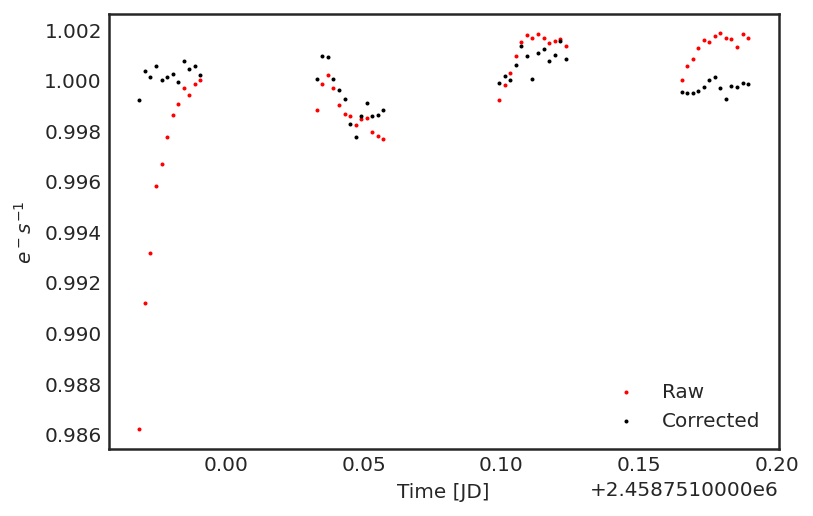

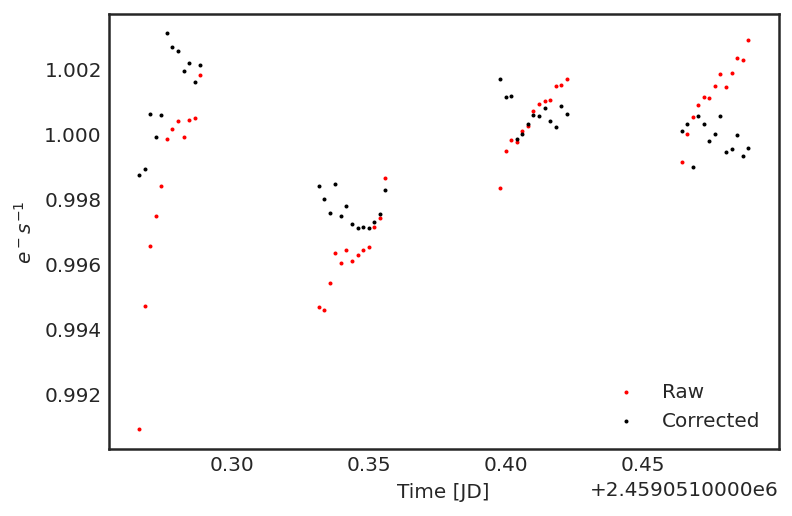

In [65]:
for visit in obs:
    visit.plot()

In [7]:
import lightkurve as lk
from astropy.stats import sigma_clipped_stats
import astropy.units as u

clc = lk.search_lightcurve('TRAPPIST-1', mission='K2', author='EVEREST').download().remove_nans()
clc.time += 2454833

tmask = np.asarray([~clc.to_periodogram('bls', period=[p, p], duration=dur).get_transit_mask(period=p, duration=dur, transit_time=t0) for p, t0, dur in zip(obs.period, obs.t0, [2/24, 2/24, 2/24])]).all(axis=0)
clc = clc.flatten(21, mask=~tmask).remove_outliers(sigma_upper=4, sigma_lower=10)

clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = sigma_clipped_stats(clc.flux.value)[2] * np.ones(clc.flux.shape[0]) * u.electron/u.s

In [8]:
np.isfinite(clc.flux_err.value).all()

True

In [18]:
obs.fit_transit(x_suppl=clc.time.value,
                y_suppl=clc.flux.value,
                yerr_suppl=clc.flux_err.value * 0.2,
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=False, fit_period=False, fit_inc=False, calc_eclipse=False, ttvs=True)

optimizing logp for variables: [y_supplmean, u_suppl, r_suppl, r_star, m_star, u, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -206740.72736778003 -> -189110.4576744
optimizing logp for variables: [r_suppl, tts_h, tts_g, tts_f, tts_e, tts_d, tts_c, tts_b, r, m_star, r_star, u, u_suppl, y_supplmean]


message: Desired error not necessarily achieved due to precision loss.
logp: -189110.4576744 -> -43377.26522014586


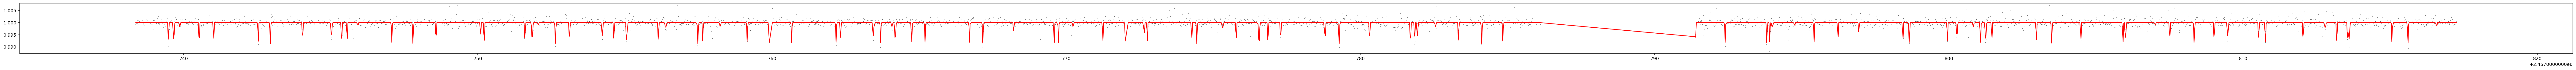

In [19]:
plt.figure(figsize=(100, 2))
plt.scatter(clc.time.value, clc.flux.value, s=0.1, c='k')
plt.plot(clc.time.value, obs.map_soln['transit_suppl'] + 1, c='r')

array([<AxesSubplot:title={'center':'Planet b'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet c'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet d'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet e'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet f'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet g'}, xlabel='Phase', ylabel='Normalized Flux'>,
       <AxesSubplot:title={'center':'Planet h'}, xlabel='Phase', ylabel='Normalized Flux'>],
      dtype=object)

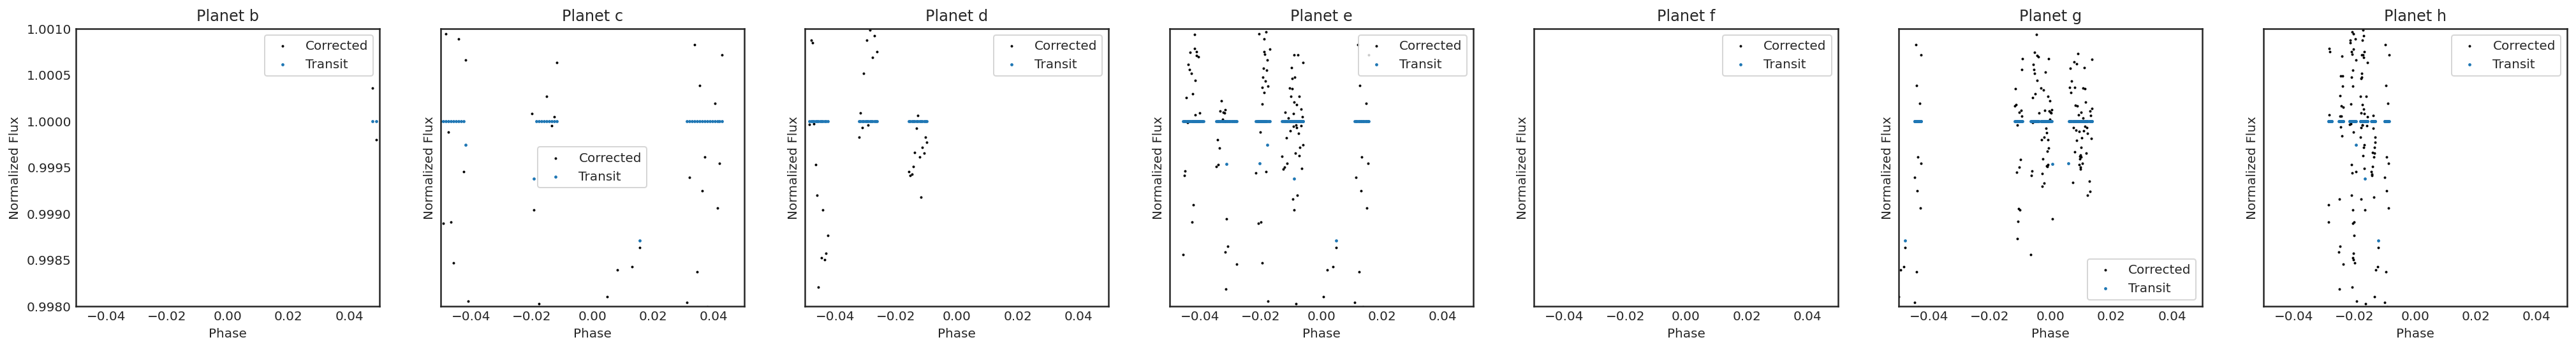

In [20]:
obs.plot(xlim=(-0.05, 0.05), ylim=(0.998, 1.001))

<AxesSubplot:xlabel='Time [JD]', ylabel='$e^-s^{-1}$'>

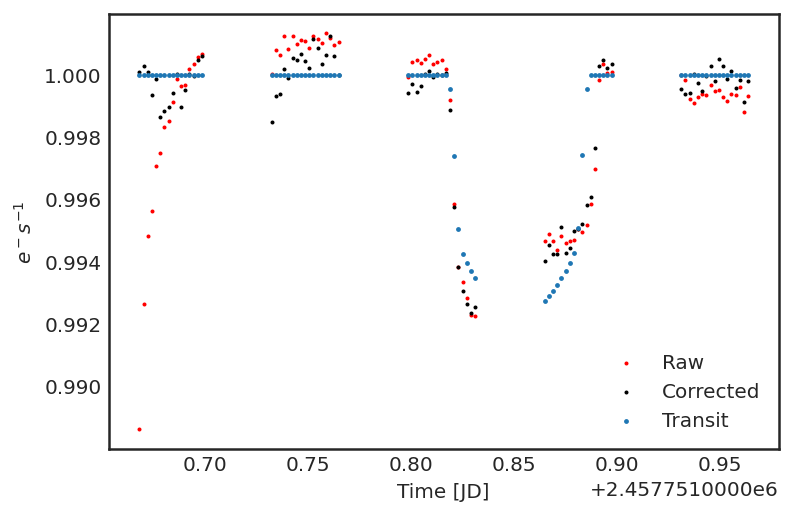

In [21]:
obs[0].plot()

In [ ]:
%debugu


In [ ]:
mlc = clc.copy()
mlc.flux = obs.map_soln['transit_suppl'] + obs.map_soln['norm_suppl']
for p, t0 in zip(obs.period, obs.t0):
    ax = clc.fold(p, t0).scatter()
    mlc.fold(p, t0).scatter(ax=ax, c='r')

In [ ]:
obs.plot()

In [ ]:
obs.fit_model()

In [ ]:
#obs.plot_spectra()

In [ ]:
om.Spectra([visit.transmission_spectrum['b'] for visit in obs if visit.transmission_spectrum['b'].spec.sum() != 0]).flatten().plot(ls='', marker='.')

In [ ]:
om.Spectra([visit.transmission_spectrum['d'] for visit in obs if visit.transmission_spectrum['d'].spec.sum() != 0]).flatten().plot(ls='', marker='.')

In [ ]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [ ]:
# from astropy.io import fits
# try:
#     hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
#     hdulist.writeto(f'results/{name}_transmission.fits')
# except:
#     pass
# try:    
#     hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
#     hdulist.writeto(f'results/{name}_emission.fits')
# except:
#     pass

In [ ]:
for visit in obs:
    visit.diagnose();
    plt.show();

In [ ]:
for visit in obs:
    visit.plot_residual_panel();
    plt.show();